# MIT 6.036 Fall 2021: Homework 4
This homework does not include provided Python code. Instead, we
encourage you to write your own code to help you answer some of these
problems, and/or test and debug the code components we do ask for.
Some of the problems below are simple enough that hand calculation
should be possible; your hand solutions can serve as test cases for
your code.  You may also find that including utilities written in
previous labs (like a `sd` or signed distance function) will be
helpful, as you build up additional functions and utilities for
calculation of margins, different loss functions, gradients, and other
functions needed for margin maximization and gradient descent.

In [ ]:
# run this cell to load the code for HW04 and to import libraries
!rm -rf code_for_hw04.py
!rm -rf __MACOSX
!wget --no-check-certificate --quiet https://go.odl.mit.edu/subject/6.036/_static/catsoop/homework/hw04/code_for_hw04.py

from code_for_hw04 import *

Importing code_for_hw04


In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

## 2) Vectorized Random Binary Classifier

Let's implement the Random linear classifier from the notes. But rather than use the `for` loop in the notes, we will be able to evaluate our random hyperplanes all at once. The process of using matrix algebra to do things we would otherwise express with loops is called "vectorization" and helps make our algorithms (for more complicated models) run fast on GPUs.

We will implement a binary linear classifier: 

$h(x; \theta, \theta_0) = \begin{cases} 
      1 & \text{if }\theta^T x + \theta_0 > 0 \\
      -1 & \text{if }\theta^T x + \theta_0 \le 0 
   \end{cases}$

### 2.2) Things are getting tensor
First, let's remind ourselves how to implement a binary linear classifier.

In [ ]:
def binary_classifier(x, theta, theta0):
    y = theta.T @ x + theta0
    return np.where(y>0, 1, -1)

Now, we want to assess $k$ binary classifiers on our data $x$ at once without using a `for` loop like in the notes. There is more than one way to do this. One simple way is to prepend a third index to our model parameters, making them tensors instead of just matrices. (The tensors must flow!) This will require us to rewrite our function. Again, there is more than one way to do this.

In the [Matrix Derivative Notes](https://canvas.mit.edu/courses/11118/files/1660235?module_item_id=434603), we introduced "implicit summation" notation, which is also known as "Einstein summation notation". This is a very helpful technique especially when you have tensors with many indices. Here's how we can "vectorize" our binary classifier to apply multiple binary classifiers at once using Einstein summation notation with `np.einsum`.


In [ ]:
def vectorized_binary_classifier(x, theta, theta0):
  """
  n = num of examples, d = dimensions of features, k = model index
  input  before -> now vectorized!
  x      [d, n] -> [d, n] (no change here since we are vectorizing over models)
  theta  [d, 1] -> [k, d, 1]
  theta0 [1, 1] -> [k, 1, 1]

  We will use the letter 'b' below to indicate our binary output index.
  """
  # Because the 'd' index is repeated and does not appear in the final 'kbn',
  # it is summed over just like we do with our regular matrix multiply @.
  y = np.einsum('kdb,dn->kbn', theta, x) + theta0
  return np.where(y>0, 1, -1)

One of the many nice things about `np.einsum` is that it handles index transposes for you!

We are also going to implement a function that takes `theta` and `theta0` and returns the "slope" and "intercept" of our hyperplane. This is a helpful function for plotting! 

In [ ]:
def slope_intercept(theta, theta0):
  return (-theta[:-1] / theta[-1], theta0/ theta[-1])

Now, let's create and plot random hyperplanes and our train and test set. We'll start with the number of hyperplanes $k=5$. See what happens when you increase the number of hyperplanes (e.g. $k=10,20,50$).

In [ ]:
###################################################################

def generate_random_hyperplanes(k, d, vmax):
  rand_theta = np.random.rand(k, d, 1) * 2 * vmax - vmax
  rand_theta0 = np.random.rand(k, 1, 1) * 2 * vmax - vmax
  return (rand_theta, rand_theta0)

def generate_random_data(n):
  center0 = np.array([-1, 0.5]).reshape(2, 1) 
  center1 = np.array([0.5, -1]).reshape(2, 1) 

  # Two overlapping clusters
  ## Train
  train_class0 = np.random.randn(2, n // 2) + center0
  train_class1 = np.random.randn(2, n // 2) + center1

  ## Test
  test_class0 = np.random.randn(2, n // 2) + center0
  test_class1 = np.random.randn(2, n // 2) + center1

  train_data = np.concatenate([train_class0, train_class1], axis=-1)
  test_data = np.concatenate([test_class0, test_class1], axis=-1)

  train_labels = np.array([-1] * (n // 2) + [1] * (n // 2))
  test_labels = np.array([-1] * (n // 2) + [1] * (n // 2))
  return train_data, test_data, train_labels, test_labels

def plot_rand_classifier(train_data, test_data, vmax):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].set_xlim([-vmax, vmax])
  ax[1].set_xlim([-vmax, vmax])
  ax[0].set_ylim([-vmax, vmax])
  ax[1].set_ylim([-vmax, vmax])
  ax[0].grid(color='lightgrey', linestyle='-', linewidth=0.5)
  ax[1].grid(color='lightgrey', linestyle='-', linewidth=0.5)
  x = np.linspace(-vmax, vmax, 100)
  for i in range(k):
    a, b = slope_intercept(rand_theta[i], rand_theta0[i])
    ax[0].plot(x, a.squeeze() * x + b.squeeze(), '-', label='%d' % (i + 1))
    ax[1].plot(x, a.squeeze() * x + b.squeeze(), '-', label='%d' % (i + 1))
  ax[0].plot(train_data[0,:n//2], train_data[1,:n//2], 'b+')
  ax[0].plot(train_data[0,n//2:], train_data[1,n//2:], 'r_')
  ax[1].plot(test_data[0,:n//2], test_data[1,:n//2], 'b+')
  ax[1].plot(test_data[0,n//2:], test_data[1,n//2:], 'r_')
  ax[0].set_title('Train set')
  ax[1].set_title('Test set')

  line_colors = np.array([matplotlib.colors.to_rgb(ax[0].lines[i].get_color()) for i in range(k)])

  handles, labels = ax[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='center right')
  return fig

  ###################################################################

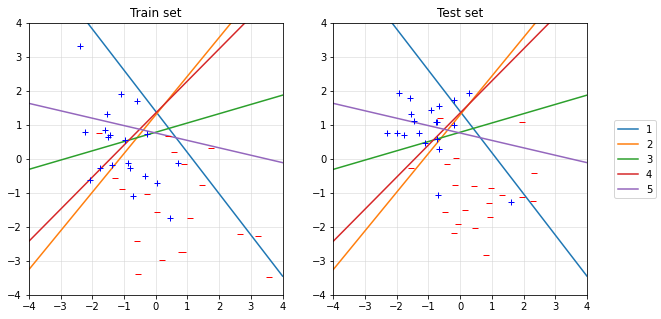

In [ ]:
### visualize_random_classifier
np.random.seed(6036)

vmax = 4
d = 2
k = 5  # 5 random models
n = 40 

train_data, test_data, train_labels, test_labels = generate_random_data(n)
rand_theta, rand_theta0 = generate_random_hyperplanes(k, d, vmax)

train_out = vectorized_binary_classifier(train_data, rand_theta, rand_theta0)
test_out = vectorized_binary_classifier(test_data, rand_theta, rand_theta0)

plot_rand_classifier(train_data, test_data, vmax);

Random linear classifiers are scored based on the best performing random hyperplane.

[QUESTION] How does the random classifier's performance improve with increasing the number of hyperplanes? I.e. adding a new random hyperplane to an existing random classifier.

* The classifier is random, so performance is also random
* Performance improves non-monotonically (might go down)
* Performance monotonically improves (might stay the same)
* Performance is guaranteed to improve every time we increase the number of hyperplanes

### 2.3) How much are we losing?

Now we're going to evaluate the loss. Given the model output $h(x)$ and labels $y$, the loss of our binary classifier is.

$E_n (h) = \frac{1}{n} \sum_{i=1}^n \begin{cases} 
      1 & h(x^{(i)}) \ne y^{(i)} \\
      0 & \text{otherwise}
   \end{cases}$

Write a function, binary_loss, that has the following input arguments:

* `output`: the output of the random classifier ($k \times 1 \times n$)
* `labels`: the true labels of the data points, copied $k$ times ($k\times 1 \times n$)

Our function `binary_loss` returns a $k \times 1$ matrix, the loss calculated for each of the $k$ classifiers.

To write this function, we will use the `numpy` function [`np.count_nonzero`](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html).

In [ ]:
def binary_loss(output, labels):
  return 1/labels.shape[2] * np.count_nonzero(output - labels, axis=2)


### 2.4) Trying things many times

Now we are going to plot the `mean` and `min` error of our random classifiers as a function of the number of random hypotheses (hyperplanes). Note that when we use our `binary_loss` function, we will need to prepend a new axis to our original labels `[1, n] -> [1, 1, n]`, so our expression can broadcast the appropriate dimensions.

In [ ]:
np.random.seed(6036)

errs_train, errs_test = [], []

n_trials = 20
hypotheses_range = [1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4]
all_hypotheses = hypotheses_range * n_trials

for i in all_hypotheses:
  rand_theta = np.random.rand(int(i), d, 1) * 2 * vmax - vmax
  rand_theta0 = np.random.rand(int(i), 1, 1) * 2 * vmax - vmax
  train_out = vectorized_binary_classifier(train_data, rand_theta, rand_theta0)
  test_out = vectorized_binary_classifier(test_data, rand_theta, rand_theta0)
  errs_train.append(binary_loss(train_out, train_labels[np.newaxis, ...]))
  errs_test.append(binary_loss(test_out, test_labels[np.newaxis, ...]))

errs_train_mean = [np.mean(x) for x in errs_train]
errs_test_mean = [np.mean(x) for x in errs_test]
errs_train_min = [np.min(x) for x in errs_train]
errs_test_min = [y[np.argmin(x)] for x,y in zip(errs_train, errs_test)]

errs_train_mean_edge = (np.min(np.array(errs_train_mean).reshape(n_trials, -1), axis=0), 
                        np.max(np.array(errs_train_mean).reshape(n_trials, -1), axis=0))
errs_test_mean_edge = (np.min(np.array(errs_test_mean).reshape(n_trials, -1), axis=0), 
                        np.max(np.array(errs_test_mean).reshape(n_trials, -1), axis=0))
errs_train_min_edge = (np.min(np.array(errs_train_min).reshape(n_trials, -1), axis=0), 
                        np.max(np.array(errs_train_min).reshape(n_trials, -1), axis=0))
errs_test_min_edge = (np.min(np.array(errs_test_min).reshape(n_trials, -1), axis=0), 
                        np.max(np.array(errs_test_min).reshape(n_trials, -1), axis=0))

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True, sharex=True)
ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].plot(all_hypotheses, errs_train_mean, 'co', label="Mean train error")
ax[0].fill_between(hypotheses_range, errs_train_mean_edge[0], errs_train_mean_edge[1], alpha=0.2, color='c')

ax[1].plot(all_hypotheses, errs_test_mean, 'mo', label="Mean test error")
ax[1].fill_between(hypotheses_range, errs_test_mean_edge[0], errs_test_mean_edge[1], alpha=0.2, color='m')

ax[0].plot(all_hypotheses, errs_train_min, 'bo', label="Minimum train error")
ax[0].fill_between(hypotheses_range, errs_train_min_edge[0], errs_train_min_edge[1], alpha=0.2, color='b')

ax[1].plot(all_hypotheses, errs_test_min, 'ro', label="Minimum test error")
ax[1].fill_between(hypotheses_range, errs_test_min_edge[0], errs_test_min_edge[1], alpha=0.2, color='r')

ax[0].set_xlabel('Number of random hyperplanes', fontsize=14)
ax[0].set_ylabel('Percent Error', fontsize=14)
ax[0].set_yticks(np.linspace(0, 1, 11))
ax[0].set_ylim(0, 1)

ax[1].set_xlabel('Number of random hyperplanes', fontsize=14)
ax[1].set_ylabel('Percent Error', fontsize=14)
ax[1].set_ylim(0, 1)

percentages = list(map(str,list(range(0, 101, 10))))
yticks = np.linspace(0, 1, 11)
ax[0].set_yticks(yticks)
ax[1].set_yticks(yticks)
ax[0].set_yticklabels(percentages)

ax[0].grid(color='lightgrey', linestyle='-', linewidth=0.5)
ax[1].grid(color='lightgrey', linestyle='-', linewidth=0.5)

ax[0].set_title("Train Data")
ax[1].set_title("Test Data")

handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[1].get_legend_handles_labels()
fig.subplots_adjust(right=0.78)
fig.legend(handles + handles2, labels + labels2, loc='center right', fontsize=12)

IndexError: ignored

## 3) Applying gradient descent to Linear Logistic Classification objective

**NOTE:** In this section,
you will code many individual functions, each of which depends on previous ones.
We **strongly recommend** that you test each of the components on your own to debug.

### 3.1) Calculating the Linear Logistic Classification (LLC) objective

First, implement the sigmoid function and implement NLL loss over the data points and separator.
Using the latter function, implement the LLC objective.
Note that these functions should work for matrix/vector arguments,
so that we can compute the objective for a whole dataset with one call.

Note that `X` <b>(Upper case X is the dataset here)</b>  is $d \times n$, `y` is $1 \times n$, `th` is $d \times 1$, `th0` is $1 \times 1$, `lam` is a scalar.

Hint: Look at `np.exp`, `np.log`


In [33]:
# returns a vector of the same shape as z
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# X is dxn, y is 1xn, th is dx1, th0 is 1x1
# returns a (1,n) array for the nll loss for each data point given th and th0 
def nll_loss(X, y, th, th0):
    n = X.shape[1]
    g = sigmoid(th.T @ X + th0)
    return -(y * np.log(g) + (1 - y) * np.log(1 - g))

# X is dxn, y is 1xn, th is dx1, th0 is 1x1, lam is a scalar
# returns a float for the llc objective over the dataset
def llc_obj(X, y, th, th0, lam):
    ans = np.asscalar(1/X.shape[1] * np.sum(nll_loss(X, y, th, th0)) + lam * (th.T @ th))
    return np.array(ans)

In [34]:
test_llc_obj(sigmoid, nll_loss, llc_obj)

Test 1 passed
Test 2 passed
Test 3 passed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  from ipykernel import kernelapp as app


### 4.2) Calculating the Linear Logistic Classification gradient

Define a function `llc_obj_grad` that returns the gradient of the logistic regression
objective function with respect to $\theta$ and $\theta_0$ in a single
column vector.  The last component of the gradient vector should be
the partial derivative with respect to $\theta_0$.  Look at
`np.vstack` as a simple way of stacking two matrices/vectors
vertically.  We have broken it down into pieces that mimic steps in
the chain rule; this leads to code that is a bit inefficient but
easier to write and debug.  We can worry about efficiency later.

Each of the test cases we provide corresponds to a function below in order. Feel free to run the tests after you finish each function to check.

In [51]:
# returns an array of the same shape as z for the gradient of sigmoid(z)
def d_sigmoid(z):
    return (1 - sigmoid(z)) * sigmoid(z)

# returns a (d,n) array for the gradient of nll_loss(X, y, th, th0) with respect to th for each data point
def d_nll_loss_th(X, y, th, th0):
    g = sigmoid(th.T @ X + th0)
    return (g - y) * X

# returns a (1,n) array for the gradient of nll_loss(X, y, th, th0) with respect to th0
def d_nll_loss_th0(X, y, th, th0):
    g = sigmoid(th.T @ X + th0)
    return g - y

# returns a (d,1) array for the gradient of llc_obj(X, y, th, th0) with respect to th
def d_llc_obj_th(X, y, th, th0, lam):
    return (1 / X.shape[1]) * np.sum(d_nll_loss_th(X, y, th, th0), axis=1, keepdims=True) + 2 * lam * th


# returns a (1,1) array for the gradient of llc_obj(X, y, th, th0) with respect to th0
def d_llc_obj_th0(X, y, th, th0, lam):
    return (1 / X.shape[1]) * np.sum(d_nll_loss_th0(X, y, th, th0), keepdims=True)


# returns a (d+1, 1) array for the full gradient as a single vector (which includes both th, th0)
def llc_obj_grad(X, y, th, th0, lam):
    return np.vstack((d_llc_obj_th(X, y, th, th0, lam), d_llc_obj_th0(X, y, th, th0, lam)))


Some test cases that may be of use are provided below.

In [52]:
test_llc_grad(d_sigmoid,d_nll_loss_th,d_nll_loss_th0,d_llc_obj_th,d_llc_obj_th0,llc_obj_grad)

Test 1 passed
Test 2 passed
Test 3 passed
Test 4 passed
Test 5 passed
Test 6 passed


### 4.3) Linear Logistic Classification minimize

Putting it all together, use the functions you built earlier to write
a gradient descent minimizer for the LLC objective.  You do not need
to paste in your previous definitions; you can just call the ones
you've defined above. For this Colab, you will need to paste the code for `gd` the gradient descent function which you implemented in [HW 3](https://canvas.mit.edu/courses/11118/assignments/126759) (on the homework page this is implemented in the checker); your function `llc_min` should return the values that `gd` does.

* Initialize all the separator parameters to zero,
* use the step size function provided below, and
* specify 10 iterations.

In [54]:
#### PASTE YOUR FUNCTION FROM HW03 ####
def gd(f, df, x0, step_size_fn, num_steps):
  x = x0
  for i in range(num_steps):
      x -= step_size_fn(i) * df(x)
  return x, f(x)

In [57]:
def llc_min(data, labels, lam):
    """
    Parameters:
        data: (d,n) array
        labels: (1,n) array
        lam: scalar
    Returns:
        same output as gd
    """
    def llc_min_step_size_fn(i):
       return 2/(i+1)**0.5
    def llc_obj_f(th):
        return llc_obj(data, labels, th[:-1], th[-1], lam)
    def llc_obj_grad_f(th):
        return llc_obj_grad(data, labels, th[:-1], th[-1], lam)
    th = np.zeros((data.shape[0] + 1, 1))
    return gd(llc_obj_f, llc_obj_grad_f, th, llc_min_step_size_fn, 10)

Test cases are shown below, where an additional separable test
data set has been specified.

In [58]:
test_llc_min(llc_min)

Test 1 passed
Test 2 passed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  from ipykernel import kernelapp as app
